<a href="https://colab.research.google.com/github/OVP2023/time_series/blob/main/dz2_time_series_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


    Возьмите из прошлого домашнего задания ряд — стационарный и не стационарный.
    Приблизьте оба варианта моделями из класса MA.
    Оцените качество и пришлите соображения, почему была выбрана та или иная модель.


In [11]:
import pandas as pd
import numpy as np

In [12]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
mean_monthly_temp = pd.read_csv("/content/drive/MyDrive/Datasets/VR/mean-monthly-air-temperature-deg.csv")
airlines_passengers = pd.read_csv("/content/drive/MyDrive/Datasets/VR/international-airline-passengers.csv")

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

all_series = {
    "Нестационарный временной ряд   International airline passengers ...": airlines_passengers["Count"],
    "Стационарный временной ряд Mean monthly air temperature ...": mean_monthly_temp["Deg"]
}

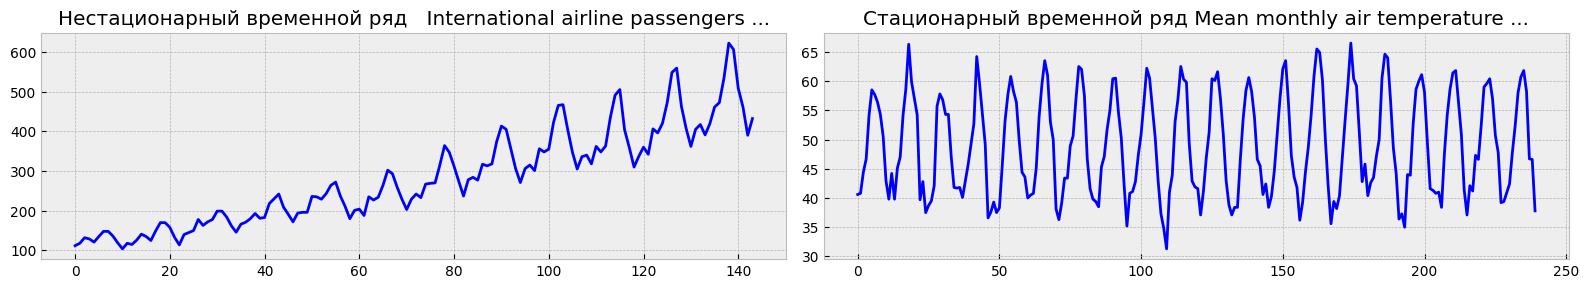

In [25]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)

        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)

    plt.tight_layout()

In [26]:
#Так как в стационарном временном ряду mean_monthly_temp["Deg"] нет сезонности и тренда, достаточно использовать скользящее среднее

def moving_average(series, n):
    if not isinstance(series, pd.Series):
        series = pd.Series(series)
    return series.rolling(n).mean()



In [27]:
ser = moving_average(mean_monthly_temp["Deg"], 3)

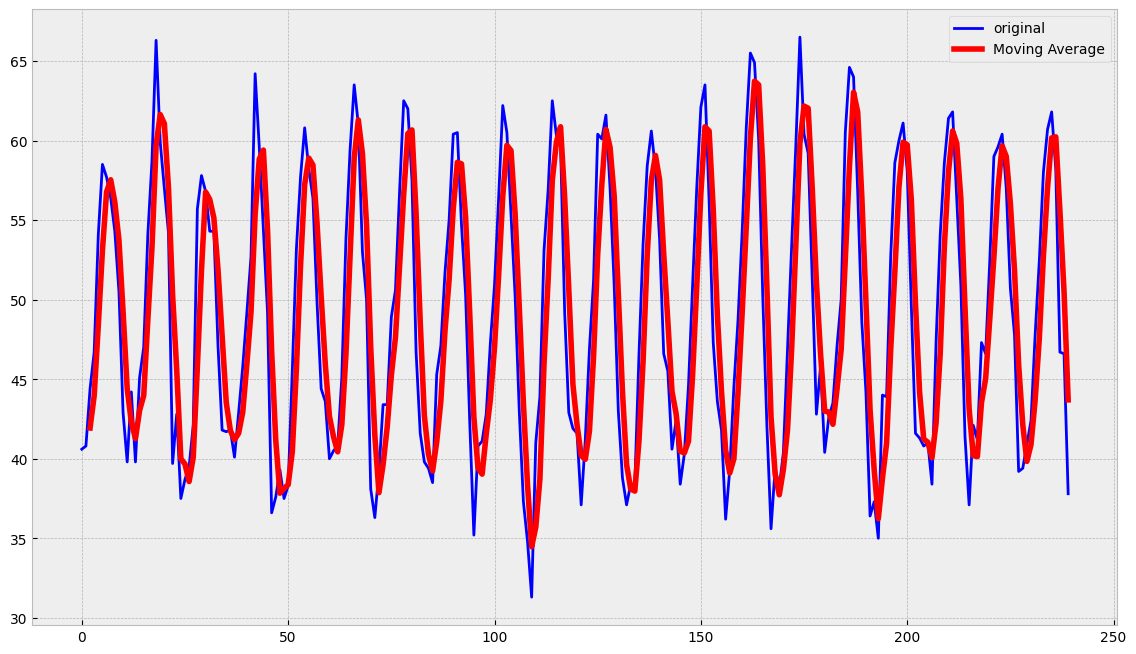

In [28]:
with plt.style.context('bmh'):
    plt.figure(figsize=(14, 8))
    plt.plot(mean_monthly_temp["Deg"], color='blue',label='original')
    plt.plot(ser, color='red', linewidth='4', label='Moving Average')
    plt.legend()

In [29]:
#Так как в не стационарном временном ряду airlines_passengers["Count"] есть сезонность и тренд, то используем метод Хольт-Винтерс / Тройное экспоненциальное сглаживание
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

def plot_tema(alpha, beta, gamma, ser=airlines_passengers["Count"], ser_to_plot=airlines_passengers["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, 12, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}".format(alpha, beta, gamma))
        plt.legend()

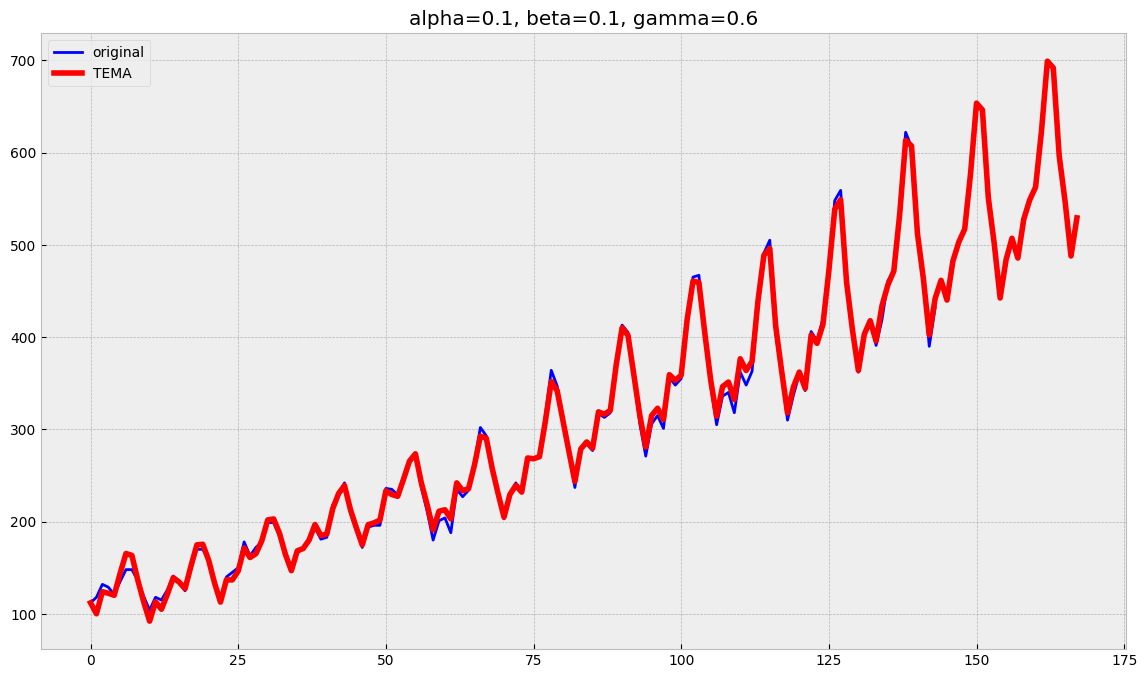

In [38]:
plot_tema(0.1, 0.1, 0.6)